# 1 Introduction

This is a data analysis about data about 891(from 2224) Titanic passengers information. You can view a description of this dataset on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.
Note that finding described this document are tentative.

# 2 Questions

Here are the questions I will try to answer:
- What were the profil caracteristics of Titanic passengers?
- What factors made people more likely to survive?


# 3 Wrangling

## 3.1 Data aquisition

First, I upload the unique csv file into a Pandas DataFrame

In [3]:
import pandas as pd
passangers=pd.read_csv('titanic-data.csv')
passangers.set_index('PassengerId',inplace=True)

## 3.2 Data cleaning

add 2 columns:
- 'estimated_age': boolean, true when age is estimated
- 'formated_age': age-0.5 when age is estimated

In [4]:
def estimated_age(age):
    if age < 1 or (age%1)==0: return False
    elif (age%1)==0.5: return True

passangers=passangers.assign(estimated_age=passangers['Age'].apply(estimated_age).tolist())
passangers=passangers.assign(formated_age=(passangers['Age']-(passangers['estimated_age']/2)).tolist())

Put full name of Embarkation Port and Unknown when it is blank

In [5]:
def port_fullname(port):
    if port == 'C': return 'Cherbourg'
    elif  port == 'Q': return 'Queenstown'
    elif  port == 'S': return 'Southampton'
    else: return 'unknown'
passangers['Embarked']=passangers['Embarked'].apply(port_fullname)

Add 'age group' column

In [6]:
def get_age_group(age):
    if age<1: return 0
    elif age<5: return 1
    elif age<30: return (age//5)*5
    else: return (age//10)*10
passangers=passangers.assign(age_group=passangers['formated_age'].apply(get_age_group).tolist())


# 4 Exploration

In [7]:
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.figure_factory as ff
import seaborn as sns
from IPython.display import display, HTML
from sklearn.cluster import KMeans
%matplotlib inline

## 4.1 values distribution and correlation

In [8]:
display(passangers.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare,formated_age,age_group
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,714.000000,714.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,29.686513,26.796919
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,14.521861,13.890857
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.420000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,20.000000,20.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,28.000000,25.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,38.000000,30.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,80.000000,80.000000


In [9]:
display(passangers.corr())

,Survived,Pclass,Age,SibSp,Parch,Fare,formated_age,age_group
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.076626,-0.081378
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.369847,-0.349749
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.999985,0.987515
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.307970,-0.311842
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.188967,-0.203813
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.096462,0.081459
formated_age,-0.076626,-0.369847,0.999985,-0.307970,-0.188967,0.096462,1.000000,0.987491
age_group,-0.081378,-0.349749,0.987515,-0.311842,-0.203813,0.081459,0.987491,1.000000


The highest correlations seems to be between:
- 'Fare' and 'Pclass' : -0.55 (The passager fare is obviously directly linked to ticket class.)
- 'Parch' and 'SibSp' : 0.41 (when pasanger have siblings / spouses aboard, they have most likely parents / children abord also)
- 'Pclass' and 'Age' : -0.37 (Older people are, higher is their ticket class.)
- 'Pclass' and 'Survived' : -0.33 (The ticket class seems to have a high impact on probability to survive.)

## 4.2 probability to survive in general

In [10]:
p_survived = len(passangers[passangers['Survived']==1])*1.0/len(passangers)
print('From the data sample, the probality to survive in general is {:.2f}'.format(p_survived))


From the data sample, the probality to survive in general is 0.38


## 4.3 probability to survive by Ticket class

In [11]:
def get_p_survived_by_ColumnName(colName):
    p_survived_by_ColumnName= \
        (passangers[passangers['Survived']==1].groupby(colName).size()/passangers.groupby(colName).size())
    
    p_survived_by_ColumnName=pd.DataFrame(p_survived_by_ColumnName,columns=['probability']) 
    p_survived_by_ColumnName.fillna(value=0,inplace=True)
    p_survived_by_ColumnName = \
        p_survived_by_ColumnName.assign(multiplication_factor=p_survived_by_ColumnName['probability']/p_survived)
    p_survived_by_ColumnName = \
        p_survived_by_ColumnName.assign(size=passangers.groupby(colName).size())
    return p_survived_by_ColumnName

display(get_p_survived_by_ColumnName('Pclass'))


,probability,multiplication_factor,size
Pclass,,,
1,0.629630,1.640351,216
2,0.472826,1.231836,184
3,0.242363,0.631418,491


People having first ticket class have 1.64 times more chance to survive.
People having second ticket class have 1.23 times more chance to survive.
People having third ticket class have 0.63 times less chance to survive.

## 4.4 Age distribution by Ticket class

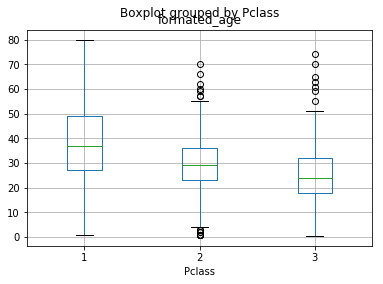

In [12]:
ax=passangers.boxplot('formated_age',by='Pclass')

It looks lile older people have more capacity to buy higher ticket class.
Note that age distribution is higher in first class.

## 4.5 Probability to survive by age

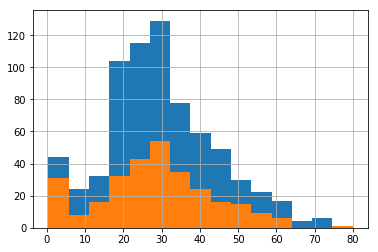

In [13]:
passangers['formated_age'].hist(bins=15)
passangers[passangers['Survived']==1]['formated_age'].hist(bins=15)


From this first graph, it looks like age is not an important factor regarding capacity to survive except maybe for youngest and oldest people. 

In [14]:
print passangers['formated_age'].describe()
print passangers[(passangers['Survived']==0)]['formated_age'].describe()

count    714.000000
mean      29.686513
std       14.521861
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: formated_age, dtype: float64
count    424.000000
mean      30.606132
std       14.165621
min        1.000000
25%       21.000000
50%       28.000000
75%       39.000000
max       74.000000
Name: formated_age, dtype: float64


Indeed, youngest death is one year old and oldest is 74 while yougest passenger is 0.42 and oldest is 80.

In [15]:
younger_dead = passangers[(passangers['Survived']==0)]['formated_age'].min()
older_dead = passangers[(passangers['Survived']==0)]['formated_age'].max()

print len(passangers[ passangers['formated_age'] < younger_dead ].index)
print len(passangers[ passangers['formated_age'] > older_dead ].index)

7
1


It appears that the seventh yougest passenger have survive and the oldest one.

           probability  multiplication_factor  size
age_group                                          
0.0           1.000000               2.605263     7
1.0           0.606061               1.578947    33
5.0           0.500000               1.302632    22
10.0          0.437500               1.139803    16
15.0          0.395349               1.029988    86
20.0          0.342105               0.891274   114
25.0          0.358491               0.933962   106
30.0          0.437126               1.138828   167
40.0          0.382022               0.995269    89
50.0          0.416667               1.085526    48
60.0          0.315789               0.822715    19
70.0          0.000000               0.000000     6
80.0          1.000000               2.605263     1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a9bb690>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11cf53190>], dtype=object)

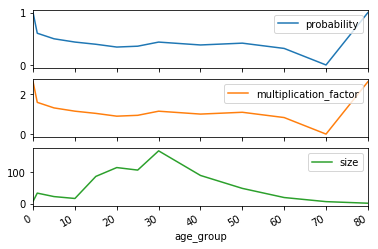

In [16]:
print get_p_survived_by_ColumnName('age_group')
get_p_survived_by_ColumnName('age_group').plot(subplots=True)

Looking at probability of survived by Age Group, we can see that all babies from the sample have survived and that the probability to survive decrease quickly until 15 years old. The number of people in the older age group is too low to take conclusion.

## 4.6 probability to survive by Sexe

,probability,multiplication_factor,size
Sex,,,
female,0.742038,1.933205,314
male,0.188908,0.492155,577


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ce1a790>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11d26c690>], dtype=object)

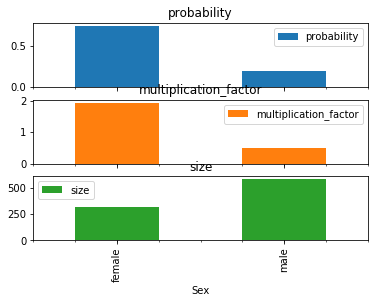

In [17]:
display(get_p_survived_by_ColumnName('Sex'))
get_p_survived_by_ColumnName('Sex').plot(kind='bar', subplots=True)

It appears that females have almost 4 times more chance to survive comparing to males.

## 4.7 probability to survive by port of embarkation

In [34]:
display (get_p_survived_by_ColumnName('Embarked'))

,probability,multiplication_factor,size
Embarked,,,
Cherbourg,0.553571,1.442199,168
Queenstown,0.389610,1.015038,77
Southampton,0.336957,0.877860,644
unknown,1.000000,2.605263,2


It appears that passangers from Cherbourg have more chance to survice and people from Southampton have less chance

## 4.8 probability to survive by number of siblings / spouses aboard

In [36]:
display (get_p_survived_by_ColumnName('SibSp'))

,probability,multiplication_factor,size
SibSp,,,
0,0.345395,0.899844,608
1,0.535885,1.396122,209
2,0.464286,1.209586,28
3,0.250000,0.651316,16
4,0.166667,0.434211,18
5,0.000000,0.000000,5
8,0.000000,0.000000,7


It appears that have one or two siblings / spouses aboard give more chance to survive

## 4.9 probability to survive by passanger fare

We already saw previously that probability to survive is very dependant from ticket class and that passager fare is corellated with ticket class.

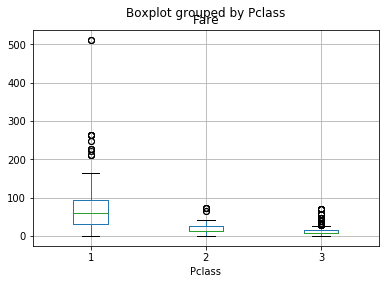

In [185]:

ax=passangers.boxplot('Fare',by='Pclass')


But, we can see that for first ticket class, the distribution is very large.

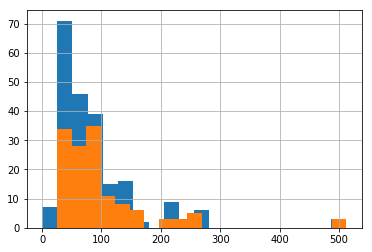

In [186]:
passangers[passangers['Pclass']==1]['Fare'].hist(bins=20)
passangers[(passangers['Survived']==1) & (passangers['Pclass']==1)]['Fare'].hist(bins=20)

From this graph, it seems that, within first class, probability to survive is increasing with passanger fare.

[[  55.94763596]
 [ 512.3292    ]
 [ 190.90702   ]]


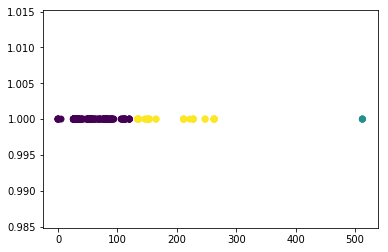

In [243]:
X=(passangers[passangers['Pclass']==1]['Fare']).values.reshape(-1,1)
y_pred = KMeans(n_clusters=3).fit(X)
plt.scatter(X[:, 0],[1]*len(X), c=y_pred.labels_)
print y_pred.cluster_centers_

,probability,multiplication_factor,size
Fare_group,,,
0.0,0.606742,1.580721,178
1.0,1.000000,2.605263,3
2.0,0.714286,1.860902,35


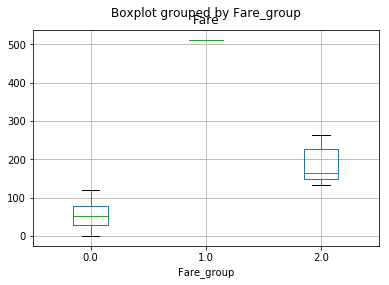

In [244]:
#del passangers['Fare_group']
passangers=passangers.assign(Fare_group=[0]*len(passangers))
y_pred = pd.DataFrame(
    data=y_pred.labels_,
    columns=['Fare_group'],
    index=passangers[passangers['Pclass']==1].index
)
passangers['Fare_group']=(passangers+y_pred)['Fare_group']
display(get_p_survived_by_ColumnName('Fare_group'))
ax=passangers.boxplot('Fare',by='Fare_group')

By clustering passagers by fare withing first class, it appears more clearly that probability to survive is increasing with passanger fare.

# 5 Conclusion

To conclude, I would say that most passagers were male, adult, coming from Southampton and travelling in third class.
But to survive, it was preferable to be children or female or comed from Cherbourg and especially travelling in first class.